Checking Gpu Device

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import torch
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In this code we sets up data loading and manipulation for our object detection tasks. We define classes for COCO and VOC bounding boxes, abstracts dataset loading with `DatasetLoader`, and implements a COCO dataset class. Then loads the images and annotations, resizes them, and prepares them for training with transformations. Additionally, it provides methods for displaying bounding boxes and their classes.

In [22]:
from collections import namedtuple, defaultdict
import abc
import os
import json
import copy
import gc
import warnings

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import ops, transforms as T
from torchvision import models
from torchvision.models.detection import (
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

warnings.filterwarnings("ignore", category=UserWarning)

from tqdm import tqdm
from time import sleep
import torch
import os
import time
from datetime import datetime
from dataclasses import dataclass
from torch import nn
from torch.utils.tensorboard import SummaryWriter



In [23]:
COCOBox_base = namedtuple("COCOBox", ["xmin", "ymin", "width", "height"])
VOCBox_base = namedtuple("VOCBox", ["xmin", "ymin", "xmax", "ymax"])


class COCOBox(COCOBox_base):
    def area(self):
        return self.width * self.height


class VOCBox(VOCBox_base):
    def area(self):
        return (self.xmax - self.xmin) * (self.ymax - self.ymin)


# Define the abstract base class for loading datasets
class DatasetLoader(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def load_images(self):
        pass

    @abc.abstractmethod
    def load_annotations(self):
        pass


# the dataset class
class CocoDataset(Dataset):
    def __init__(self, image_folder, annotations_file, width, height, transforms=None):

        self.transforms = transforms
        self.image_folder = image_folder
        self.annotations_file = annotations_file
        self.height = height
        self.width = width

        if not isinstance(self.image_folder, str):
            raise ValueError("image_folder should be a string")

        if not isinstance(annotations_file, str):
            raise ValueError("annotations_file should be a string")

        self.annotations_file = annotations_file
        self.image_folder = image_folder
        self.width = width
        self.height = height

        with open(annotations_file, "r") as f:
            self.annotations = json.load(f)

        self.image_ids = {}  # Change to a regular dictionary
        for i in self.annotations["images"]:
            self.image_ids[i["id"]] = i  # key = image_id

        self.annotation_ids = defaultdict(list)
        for i in self.annotations["annotations"]:
            self.annotation_ids[i["image_id"]].append(i)  # key = image_id

        self.cats_id2label = {}
        self.label_names = []

        first_label_id = self.annotations["categories"][0]["id"]
        if first_label_id == 0:
            for i in self.annotations["categories"][1:]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        if first_label_id == 1:
            for i in self.annotations["categories"]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        if first_label_id > 1:
            raise AssertionError(
                "Something went wrong in categories, check the annotation file!"
            )

    def get_total_classes_count(self):
        return len(self.cats_id2label)

    def get_classnames(self):
        return [v for k, v in self.cats_id2label.items()]

    def load_images_annotations(self, index):
        image_info = self.image_ids[index]  # Access image info directly
        image_path = os.path.join(self.image_folder, image_info["file_name"])

        image = cv2.imread(image_path)
        rimage = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )  # .astype(np.float32) # convert BGR to RGB color format
        rimage = cv2.resize(rimage, (self.width, self.height))
        # rimage /= 255.0
        rimage = Image.fromarray(rimage)

        image_height, image_width = (
            image_info["height"],
            image_info["width"],
        )  # original height & width
        anno_info = self.annotation_ids[index]

        if len(anno_info) == 0:  # for negative images (Images without annotations)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0, 1), dtype=torch.int64)
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = []
            labels_id = []

            for ainfo in anno_info:
                xmin, ymin, w, h = ainfo["bbox"]
                xmax, ymax = xmin + w, ymin + h

                xmin_final = (xmin / image_width) * self.width
                xmax_final = (xmax / image_width) * self.width
                ymin_final = (ymin / image_height) * self.height
                ymax_final = (ymax / image_height) * self.height

                category_id = ainfo["category_id"]

                boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
                labels_id.append(category_id)

            boxes = torch.as_tensor(
                boxes, dtype=torch.float32
            )  # bounding box to tensor
            area = (boxes[:, 3] - boxes[:, 1]) * (
                boxes[:, 2] - boxes[:, 0]
            )  # area of the bounding boxes
            iscrowd = torch.zeros(
                (boxes.shape[0],), dtype=torch.int64
            )  # no crowd instances
            labels = torch.as_tensor(labels_id, dtype=torch.int64)  # labels to tensor

        # final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([index])
        target["image_id"] = image_id

        return {
            "image": rimage,
            "height": image_height,
            "width": image_width,
            "target": target,
        }

    @staticmethod
    def transform_image_for_inference(image_path, width, height):

        image = cv2.imread(image_path)
        ori_h, ori_w, _ = image.shape

        oimage = copy.deepcopy(image)
        oimage = Image.fromarray(oimage)
        oimage = T.ToTensor()(oimage)

        rimage = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )
        rimage = cv2.resize(rimage, (width, height))
        rimage = Image.fromarray(rimage)
        rimage = T.ToTensor()(rimage)
        # rimage = torch.unsqueeze(rimage, 0)

        transform_info = {
            "original_width": ori_w,
            "original_height": ori_h,
            "resized_width": width,
            "resized_height": height,
            "resized_image": rimage,
            "original_image": oimage,
        }

        return transform_info  # this can directly go to model for inference

    @staticmethod
    def display_bbox(
        bboxes, fig, ax, classes=None, in_format="xyxy", color="y", line_width=3
    ):
        if type(bboxes) == np.ndarray:
            bboxes = torch.from_numpy(bboxes)
        if classes:
            assert len(bboxes) == len(classes)
        # convert boxes to xywh format
        bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt="xywh")
        c = 0
        for box in bboxes:
            x, y, w, h = box.numpy()
            # display bounding box
            rect = patches.Rectangle(
                (x, y),
                w,
                h,
                linewidth=line_width,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            # display category
            if classes:
                if classes[c] == "pad":
                    continue
                ax.text(
                    x + 5,
                    y + 20,
                    classes[c],
                    bbox=dict(facecolor="yellow", alpha=0.5),
                )
            c += 1

        return fig, ax

    def __getitem__(self, idx):
        # Check if idx is within the bounds of self.image_ids
        if idx >= len(self.image_ids):
            # Handle the case where idx is out of bounds,
            # for example, by returning a default image or raising an error
            raise IndexError(
                f"Index {idx} is out of bounds for dataset with {len(self.image_ids)} images"
            )

        # If idx is within bounds, proceed with the existing code
        image_id_list = list(self.image_ids.keys())
        actual_image_id = image_id_list[
            idx
        ]  # get the actual image id from the list
        sample = self.load_images_annotations(
            actual_image_id
        )  # load using the actual image id
        image_resized = sample["image"]
        target = sample["target"]

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(
                image=image_resized,
                bboxes=target["boxes"],
                labels=sample["labels"],
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return T.ToTensor()(image_resized), target

    def __len__(self):
        return len(self.image_ids)

In this  section we sets up a Faster R-CNN model for the detection task. It imports necessary modules, suppresses user warnings, and defines a function `create_model()` to instantiate the model. The function configures the pre-trained Faster R-CNN ResNet-50 FPN architecture, adjusts the output layer for the given number of classes, and loads a checkpoint if provided. Finally, it returns the configured model.

In [24]:
def create_model(num_classes,checkpoint=None,device='cuda'):
    """
    Create a model for object detection using the Faster R-CNN architecture.

    Parameters:
    - num_classes (int): The number of classes for object detection. (Total classes + 1 [for background class])
    - checkpoint (str) : checkpoint path for the pretrained custom model
    - device (str) : cpu / cuda
    Returns:
    - model (torchvision.models.detection.fasterrcnn_resnet50_fpn): The created model for object detection.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True,
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        pretrained_backbone=True,
        #weights_backbone = 'ResNet50_Weights.DEFAULT',
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if checkpoint:
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model = model.to(device)
    return model

In this code we define two classes: `InferFasterRCNN` for inference with a Faster R-CNN model and `SaveBestModel` for saving the best model during training. `InferFasterRCNN` allows model loading, image inference, and visualization of predicted bounding boxes. It includes methods for image inference both with an image tensor and directly from an image file path. `SaveBestModel` saves the best model during training based on the validation loss.  Additionally, a utility function `display_gt_pred` is provided for visualizing ground truth and predicted bounding boxes on an image.

In [25]:
class InferFasterRCNN:
    def __init__(self, num_classes=None, classnames=[]):

        assert type(num_classes) != type(None), "Define number of classes"

        self.num_classes = num_classes  # total_class_no + 1 (for background)

        self.classnames = ["__background__"]
        self.classnames.extend(classnames)

        self.colors = np.random.uniform(0, 255, size=(len(self.classnames), 3))

        assert (
            len(self.classnames) == self.num_classes
        ), f"num_classes: {self.num_classes}, len(classnames): {len(self.classnames)}.\
            num_classes should be equal to count of actual classes in classnames list without background + 1"

    def load_model(self, checkpoint, device="cpu"):
        self.device = device
        self.model = create_model(
            self.num_classes, checkpoint=checkpoint, device=self.device
        )
        self.model = self.model.eval()

    def infer_image(self, transform_info ,detection_threshold=0.5, visualize=False):

        '''
        image : original unscaled image
        '''

        display_unscaled = True
        h_ratio = transform_info['original_height']/transform_info['resized_height']
        w_ratio = transform_info['original_width']/transform_info['resized_width']

        orig_image = transform_info['resized_image']
        orig_image = orig_image.cpu().numpy()
        orig_image = np.transpose(orig_image, (1, 2, 0))
        orig_image = np.ascontiguousarray(orig_image, dtype=np.float32)
        image = torch.unsqueeze(transform_info['resized_image'], 0)

        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]

        results = {}
        _f_boxes,_f_scores,_f_labels = [],[],[]

        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy() # xyxy
            scores = outputs[0]["scores"].data.numpy()
            labels = outputs[0]["labels"].cpu().numpy()

            # filter out boxes according to `detection_threshold`
            for i in range(len(boxes)):
                if scores[i] >= detection_threshold:
                    _f_boxes.append(boxes[i])
                    _f_labels.append(labels[i])
                    _f_scores.append(scores[i])

            boxes,labels,scores = _f_boxes,_f_labels,_f_scores
            #boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in labels
            ]

            results['unscaled_boxes'] = [[i[0]*w_ratio, i[1]*h_ratio, i[2]*w_ratio, i[3]*h_ratio] for i in boxes] # in original image size
            results['scaled_boxes'] = boxes # in resize image size
            results['scores'] = scores
            results['pred_classes'] = pred_classes
            results['labels'] = labels

            if not display_unscaled:
                # draw the bounding boxes and write the class name on top of it
                for j, box in enumerate(draw_boxes):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(orig_image[:,:,::-1])
                    plt.show()

            else:
                # draw the bounding boxes and write the class name on top of it
                draw_boxes_scaled = results['unscaled_boxes']
                scaled_orig_image = transform_info['original_image']
                scaled_orig_image = scaled_orig_image.cpu().numpy()
                scaled_orig_image = np.transpose(scaled_orig_image, (1, 2, 0))
                scaled_orig_image = np.ascontiguousarray(scaled_orig_image, dtype=np.float32)

                for j, box in enumerate(draw_boxes_scaled):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        scaled_orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        scaled_orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(scaled_orig_image)  # [:,:,::-1])
                    plt.show()

        return results

    def infer_image_path(self, image_path, detection_threshold=0.5, visualize=False):

        image = cv2.imread(image_path)
        orig_image = image.copy()

        # BGR to RGB
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # make the pixel range between 0 and 1
        image /= 255.0
        # bring color channels to front
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # convert to tensor
        image = torch.tensor(image, dtype=torch.float).cpu()

        # add batch dimension
        image = torch.unsqueeze(image, 0)
        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]


        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy()
            scores = outputs[0]["scores"].data.numpy()

            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in outputs[0]["labels"].cpu().numpy()
            ]

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                class_name = pred_classes[j]
                color = self.colors[self.classnames.index(class_name)]
                cv2.rectangle(
                    orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color,
                    2,
                )
                cv2.putText(
                    orig_image,
                    class_name,
                    (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    color,
                    2,
                    lineType=cv2.LINE_AA,
                )

            if visualize:
                plt.figure(figsize=(10, 10))
                plt.imshow(orig_image[:, :, ::-1])
                plt.show()

        return outputs


    def draw_bounding_boxes(self,image, bboxes, class_labels, figsize=(12,12)):
        class_labels = class_labels.cpu().numpy()
        bboxes = bboxes.cpu().numpy()
        for j, box in enumerate(bboxes):
            label = class_labels[j]
            color = self.colors[label]
            cv2.rectangle(
                    image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0,200,0),
                    1,
                )
            cv2.putText(
                image,
                self.classnames[int(label)],
                (int(box[0] + 15), int(box[1] + 15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0,200,0),
                2,
                lineType=cv2.LINE_AA,
            )

        plt.figure(figsize=figsize)
        plt.imshow(image)
        plt.show()


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """

    def __init__(
        self, best_valid_loss=float("inf"), output_dir="weight_outputs",
    ):
        self.best_valid_loss = best_valid_loss

        os.makedirs(output_dir, exist_ok=True)

        self.output_dir = output_dir

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                f"{self.output_dir}/best_model.pth",
            )

def display_gt_pred(image_path,
                    gt_boxes,
                    pred_boxes,
                    gt_class,
                    pred_class,
                    pred_scores,
                    box_format='xywh',
                    figsize=(10,10),
                    classnames = []):

    line_width = 1
    gt_color = 'g'
    pred_color = 'r'
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img[:,:,::-1])

    for gb,gc in zip(gt_boxes,gt_class):

        if format == 'xywh':
            x, y, w, h = gb

        if box_format == 'xyxy':
            x1, y1, x2, y2 = gb
            x,y,w,h = x1,y1,x2-x1,y2-y1

        rect = patches.Rectangle(
                (x, y), w, h, linewidth=line_width, edgecolor=gt_color, facecolor="none"
            )
        ax.add_patch(rect)

        if len(classnames)>0:
            ax.text(x + 5, y + 20, classnames[int(gc)-1], bbox=dict(facecolor="yellow", alpha=0.5))
        else:
            ax.text(x + 5, y + 20, gc, bbox=dict(facecolor="yellow", alpha=0.5))

    for pb,pc,ps in zip(pred_boxes,pred_class,pred_scores):
        if format == 'xywh':
            x, y, w, h = pb
        if box_format == 'xyxy':
            x1, y1, x2, y2 = pb
            x,y,w,h = x1,y1,x2-x1,y2-y1
        rect = patches.Rectangle(
                (x, y), w, h, linewidth=line_width+1, edgecolor=pred_color, facecolor="none"
            )
        ax.add_patch(rect)
        ax.text(x + 5, y + 40, f'{pc},{round(ps*100,2)}', bbox=dict(facecolor="red", alpha=0.5))

    plt.axis('off')
    plt.show()

In this code  we define functions for training and validating object detection models using Faster R-CNN. It includes functions for loading datasets, training and validating models for one epoch each, and saving the best model based on validation loss. The training and validation loops iterate over batches, calculating and optimizing losses, and logging metrics using tqdm and TensorBoard.

In [26]:
def get_datasets(train_image_dir:str,
                 val_image_dir:str,
                 train_coco_json:str,
                 val_coco_json:str):

    train_ds = CocoDataset(
        image_folder=train_image_dir,
        annotations_file=train_coco_json,
        height=640,
        width=640,
    )

    val_ds = CocoDataset(
        image_folder=val_image_dir,
        annotations_file=val_coco_json,
        height=640,
        width=640,
    )

    return train_ds, val_ds

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), output_dir = 'weight_outputs',
    ):
        self.best_valid_loss = best_valid_loss

        os.makedirs(output_dir,exist_ok=True)

        self.output_dir = output_dir

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
        self.model_save_path = f'{self.output_dir}/best_model.pth'
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, self.model_save_path)

@torch.inference_mode()
def val_one_epoch(model, val_dl, writer, epoch_no, total_epoch, device, log=True):
    with tqdm(val_dl, unit="batch") as tepoch:
        epoch_loss = 0
        _classifier_loss = 0
        _loss_box_reg = 0
        _loss_rpn_box_reg = 0
        _loss_objectness = 0
        for data in tepoch:
            tepoch.set_description(f"Val:Epoch {epoch_no}/{total_epoch}")
            imgs = []
            targets = []
            for d in data:
                imgs.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device)
                targets.append(targ)
            loss_dict = model(imgs, targets)

            loss = sum(v for v in loss_dict.values())
            classifier_loss = loss_dict.get("loss_classifier").cpu().detach().numpy()
            loss_box_reg = loss_dict.get("loss_box_reg").cpu().detach().numpy()
            loss_objectness = loss_dict.get("loss_objectness").cpu().detach().numpy()
            loss_rpn_box_reg = loss_dict.get("loss_rpn_box_reg").cpu().detach().numpy()

            epoch_loss += loss.cpu().detach().numpy()
            _classifier_loss += classifier_loss
            _loss_box_reg += loss_box_reg
            _loss_objectness += loss_objectness
            _loss_rpn_box_reg += loss_rpn_box_reg

            tepoch.set_postfix(
                total_loss=epoch_loss,
                loss_classifier=_classifier_loss,
                boxreg_loss=_loss_box_reg,
                obj_loss=_loss_objectness,
                rpn_boxreg_loss=_loss_rpn_box_reg,
            )

        if log:
            writer.add_scalar("Val/total_loss", epoch_loss, epoch_no)
            writer.add_scalar("Val/classifier_loss", _classifier_loss, epoch_no)
            writer.add_scalar("Val/box_reg_loss", _loss_box_reg, epoch_no)
            writer.add_scalar("Val/objectness_loss", _loss_objectness, epoch_no)
            writer.add_scalar("Val/rpn_box_reg_loss", _loss_rpn_box_reg, epoch_no)

    return writer, epoch_loss

def train_one_epoch(model, train_dl, optimizer, writer, epoch_no, total_epoch, device):
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        _classifier_loss = 0
        _loss_box_reg = 0
        _loss_rpn_box_reg = 0
        _loss_objectness = 0
        for data in tepoch:
            tepoch.set_description(f"Train:Epoch {epoch_no}/{total_epoch}")
            imgs = []
            targets = []
            for d in data:
                imgs.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device)
                targets.append(targ)
            loss_dict = model(imgs, targets)

            loss = sum(v for v in loss_dict.values())
            classifier_loss = loss_dict.get("loss_classifier").cpu().detach().numpy()
            loss_box_reg = loss_dict.get("loss_box_reg").cpu().detach().numpy()
            loss_objectness = loss_dict.get("loss_objectness").cpu().detach().numpy()
            loss_rpn_box_reg = loss_dict.get("loss_rpn_box_reg").cpu().detach().numpy()

            epoch_loss += loss.cpu().detach().numpy()
            _classifier_loss += classifier_loss
            _loss_box_reg += loss_box_reg
            _loss_objectness += loss_objectness
            _loss_rpn_box_reg += loss_rpn_box_reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(
                total_loss=epoch_loss,
                loss_classifier=_classifier_loss,
                boxreg_loss=_loss_box_reg,
                obj_loss=_loss_objectness,
                rpn_boxreg_loss=_loss_rpn_box_reg,
            )

        writer.add_scalar("Train/total_loss", epoch_loss, epoch_no)
        writer.add_scalar("Train/classifier_loss", _classifier_loss, epoch_no)
        writer.add_scalar("Train/box_reg_loss", _loss_box_reg, epoch_no)
        writer.add_scalar("Train/objectness_loss", _loss_objectness, epoch_no)
        writer.add_scalar("Train/rpn_box_reg_loss", _loss_rpn_box_reg, epoch_no)

    return model, optimizer, writer, epoch_loss

In this script we evaluated our model using the COCO dataset and metrics. It loads images and ground truth annotations, runs inference using a Faster R-CNN model, and evaluates the model's performance using COCO metrics like AP. The results are saved in JSON format, evaluated against ground truth annotations, and metrics such as AP@50 and AP@50:95 are computed and returned. Finally, memory is cleared for efficient resource usage.

In [27]:
def save_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file)

def evaluate_model(image_dir,
                   gt_ann_file,
                   model_weight):

    _ds = CocoDataset(
            image_folder=image_dir,
            annotations_file=gt_ann_file,
            height=640,
            width=640,
        )

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    IF_C = InferFasterRCNN(num_classes=_ds.get_total_classes_count() + 1,
                        classnames=_ds.get_classnames())

    IF_C.load_model(checkpoint=model_weight,
                    device=device)

    image_dir = image_dir

    cocoGt=COCO(annotation_file=gt_ann_file)
    imgIds = cocoGt.getImgIds() # all image ids

    res_id = 1
    res_all = []

    # The issue was here where "id" variable was being used as both image id and index for iterating.
    # The following change iterates through the image IDs directly.
    for image_id in tqdm(imgIds,total=len(imgIds)):

        # Load image information using the correct image ID
        img_info = cocoGt.loadImgs(image_id)[0]
        annIds = cocoGt.getAnnIds(imgIds=img_info['id'])
        ann_info = cocoGt.loadAnns(annIds)
        image_path = os.path.join(image_dir,
                                img_info['file_name'])
        transform_info = CocoDataset.transform_image_for_inference(image_path,width=640,height=640)
        result = IF_C.infer_image(transform_info=transform_info,
                                visualize=False)

        if len(result)>0:
            pred_boxes_xyxy = result['unscaled_boxes']
            pred_boxes_xywh = [[i[0],i[1],i[2]-i[0],i[3]-i[1]] for i in pred_boxes_xyxy]
            pred_classes = result['pred_classes']
            pred_scores = result['scores']
            pred_labels = result['labels']

            for i in range(len(pred_boxes_xywh)):
                res_temp = {"id":res_id,
                            "image_id":image_id, #Using actual image id to store in results
                            "bbox":pred_boxes_xywh[i],
                            "segmentation":[],
                            "iscrowd": 0,
                            "category_id": int(pred_labels[i]),
                            "area":pred_boxes_xywh[i][2]*pred_boxes_xywh[i][3],
                            "score": float(pred_scores[i])}
                res_all.append(res_temp)
                res_id+=1

    save_json_path = 'test_dect.json'
    save_json(res_all,save_json_path)

    cocoGt=COCO(gt_ann_file)
    cocoDt=cocoGt.loadRes(save_json_path)

    cocoEval = COCOeval(cocoGt,cocoDt,iouType='bbox')
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    AP_50_95 = cocoEval.stats.tolist()[0]
    AP_50 = cocoEval.stats.tolist()[1]

    del IF_C,_ds
    os.remove(save_json_path)

    torch.cuda.empty_cache()
    gc.collect()

    return {'AP_50_95':AP_50_95,
            'AP_50':AP_50}

The below script trains a Faster R-CNN model for object detection using PyTorch. It initializes datasets for training and validation, defines the model architecture, optimizer, and training loop. The training loop iterates over epochs, evaluating the model on the validation dataset periodically. The best model based on validation loss is saved, and TensorBoard is used for visualization. Finally, the script saves the best model's hyperparameters and performance metrics.

In [35]:
%cd /content/drive/MyDrive/Job Task

/content/drive/MyDrive/Job Task


In [36]:
!ls

coco_Dataset  faster_rcnn_training.ipynb  predict_with_faster_rcnn.ipynb


In [37]:
def train(
    train_dataset,
    val_dataset,
    epochs=2,
    batch_size=8,
    exp_folder="exp",
    val_eval_freq=1,
):

    date_format = "%d-%m-%Y-%H-%M-%S"
    date_string = time.strftime(date_format)

    exp_folder = os.path.join("exp", "summary", date_string)
    writer = SummaryWriter(exp_folder)

    def custom_collate(data):
        return data

    # Dataloaders --
    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=custom_collate,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    val_dl = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=custom_collate,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    # Device --
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Model --
    faster_rcnn_model = create_model(train_dataset.get_total_classes_count() + 1)
    faster_rcnn_model = faster_rcnn_model.to(device)

    # Optimizer --
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups

    for k, v in faster_rcnn_model.named_modules():
        if hasattr(v, "bias") and isinstance(v.bias, nn.Parameter):
            pg2.append(v.bias)  # biases
        if isinstance(v, nn.BatchNorm2d) or "bn" in k:
            pg0.append(v.weight)  # no decay
        elif hasattr(v, "weight") and isinstance(v.weight, nn.Parameter):
            pg1.append(v.weight)  # apply decay

    optimizer = torch.optim.SGD(
        pg0, lr=0.001, momentum=0.9, nesterov=True
    ) # BN

    optimizer.add_param_group(
        {"params": pg1, "weight_decay":  5e-4}
    )  # add pg1 with weight_decay # Weights

    optimizer.add_param_group({"params": pg2}) # Biases


    num_epochs = epochs
    save_best_model = SaveBestModel(output_dir=exp_folder)

    for epoch in range(num_epochs):

        faster_rcnn_model, optimizer, writer, epoch_loss = train_one_epoch(
            faster_rcnn_model,
            train_dl,
            optimizer,
            writer,
            epoch + 1,
            num_epochs,
            device,
        )

        sleep(0.1)

        if (epoch % val_eval_freq == 0) and epoch != 0:  # Do evaluation of validation set
            eval_result = evaluate_model(image_dir=val_dataset.image_folder,
                                         gt_ann_file=val_dataset.annotations_file,
                                         model_weight=save_best_model.model_save_path)

            sleep(0.1)

            writer.add_scalar("Val/AP_50_95", eval_result['AP_50_95'], epoch + 1)
            writer.add_scalar("Val/AP_50", eval_result['AP_50'], epoch + 1)

        else:
            writer, val_epoch_loss = val_one_epoch(
                faster_rcnn_model,
                val_dl,
                writer,
                epoch + 1,
                num_epochs,
                device,
                log=True,
            )

            sleep(0.1)

            save_best_model(val_epoch_loss,
                            epoch,
                            faster_rcnn_model,
                            optimizer)


    _, _ = val_one_epoch(
        faster_rcnn_model, val_dl, writer, epoch + 1, num_epochs, device, log=False
    )

    writer.add_hparams(
        {"epochs": epochs, "batch_size": batch_size},
        {"Train/total_loss": epoch_loss, "Val/total_loss": val_epoch_loss},
    )


if __name__ == "__main__":
    train_image_dir: str = r"/content/drive/MyDrive/Job Task/coco_Dataset/training_images"
    val_image_dir: str = r"/content/drive/MyDrive/Job Task/coco_Dataset/validation_images"
    train_coco_json: str = r"/content/drive/MyDrive/Job Task/coco_Dataset/training_images/training.json"
    val_coco_json: str = r"/content/drive/MyDrive/Job Task/coco_Dataset/validation_images/validation.json"

    epochs: int = 100
    batch_size: int = 8
    val_eval_freq: int = 2
    exp_folder: str = '/content/drive/MyDrive/Job Task/FasterRCNN/V1/exp'

    train_ds, val_ds = get_datasets(train_image_dir=train_image_dir,
                                    train_coco_json=train_coco_json,
                                    val_image_dir=val_image_dir,
                                    val_coco_json=val_coco_json)
    train(train_ds, val_ds,
          epochs=epochs,
          batch_size=batch_size,
          val_eval_freq=val_eval_freq,
          exp_folder=exp_folder)


Val:Epoch 1/100: 100%|██████████| 10/10 [00:09<00:00,  1.08batch/s, boxreg_loss=2.73, loss_classifier=2.88, obj_loss=1.09, rpn_boxreg_loss=0.221, total_loss=6.92]



Best validation loss: 6.922692835330963

Saving best model for epoch: 1



Val:Epoch 2/100: 100%|██████████| 10/10 [00:08<00:00,  1.17batch/s, boxreg_loss=2.59, loss_classifier=2.22, obj_loss=1.03, rpn_boxreg_loss=0.207, total_loss=6.05]



Best validation loss: 6.053482413291931

Saving best model for epoch: 2



Train:Epoch 3/100: 100%|██████████| 37/37 [01:00<00:00,  1.64s/batch, boxreg_loss=9.58, loss_classifier=7.36, obj_loss=0.954, rpn_boxreg_loss=0.635, total_loss=18.5]
<ipython-input-27-9ced22c66bb5>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:15<00:00,  5.08it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 4/100: 100%|██████████| 10/10 [00:08<00:00,  1.16batch/s, boxreg_loss=2.2, loss_classifier=1.72, obj_loss=0.986, rpn_boxreg_loss=0.196, total_loss=5.11]



Best validation loss: 5.1075239777565

Saving best model for epoch: 4



Train:Epoch 5/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=7.88, loss_classifier=5.96, obj_loss=0.658, rpn_boxreg_loss=0.553, total_loss=15]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  6.69it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 6/100: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, boxreg_loss=1.82, loss_classifier=1.59, obj_loss=1.01, rpn_boxreg_loss=0.191, total_loss=4.61]



Best validation loss: 4.608640983700752

Saving best model for epoch: 6



Train:Epoch 7/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=6.43, loss_classifier=5.29, obj_loss=0.439, rpn_boxreg_loss=0.48, total_loss=12.6]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 8/100: 100%|██████████| 10/10 [00:09<00:00,  1.10batch/s, boxreg_loss=1.63, loss_classifier=1.5, obj_loss=1.1, rpn_boxreg_loss=0.191, total_loss=4.43]



Best validation loss: 4.427039474248886

Saving best model for epoch: 8



Train:Epoch 9/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=5.7, loss_classifier=4.91, obj_loss=0.342, rpn_boxreg_loss=0.44, total_loss=11.4]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.16it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 10/100: 100%|██████████| 10/10 [00:08<00:00,  1.15batch/s, boxreg_loss=1.56, loss_classifier=1.46, obj_loss=1.17, rpn_boxreg_loss=0.192, total_loss=4.38]



Best validation loss: 4.383629962801933

Saving best model for epoch: 10



Train:Epoch 11/100: 100%|██████████| 37/37 [01:00<00:00,  1.65s/batch, boxreg_loss=5.12, loss_classifier=4.48, obj_loss=0.255, rpn_boxreg_loss=0.415, total_loss=10.3]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.44it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 13/100: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch, boxreg_loss=4.72, loss_classifier=4.14, obj_loss=0.242, rpn_boxreg_loss=0.374, total_loss=9.48]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.32it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 15/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=4.37, loss_classifier=3.8, obj_loss=0.187, rpn_boxreg_loss=0.364, total_loss=8.71]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:12<00:00,  6.31it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 16/100: 100%|██████████| 10/10 [00:09<00:00,  1.10batch/s, boxreg_loss=1.4, loss_classifier=1.33, obj_loss=1.45, rpn_boxreg_loss=0.196, total_loss=4.37]



Best validation loss: 4.371735408902168

Saving best model for epoch: 16



Train:Epoch 17/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=4.02, loss_classifier=3.5, obj_loss=0.146, rpn_boxreg_loss=0.345, total_loss=8]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 19/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=3.82, loss_classifier=3.3, obj_loss=0.131, rpn_boxreg_loss=0.325, total_loss=7.58]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:13<00:00,  5.95it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 21/100: 100%|██████████| 37/37 [01:00<00:00,  1.64s/batch, boxreg_loss=3.52, loss_classifier=3.04, obj_loss=0.12, rpn_boxreg_loss=0.308, total_loss=6.99]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:14<00:00,  5.36it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 23/100: 100%|██████████| 37/37 [00:59<00:00,  1.60s/batch, boxreg_loss=3.37, loss_classifier=2.9, obj_loss=0.101, rpn_boxreg_loss=0.309, total_loss=6.68]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 25/100: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch, boxreg_loss=3.13, loss_classifier=2.68, obj_loss=0.0914, rpn_boxreg_loss=0.287, total_loss=6.2]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  7.08it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 27/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=2.96, loss_classifier=2.52, obj_loss=0.0958, rpn_boxreg_loss=0.27, total_loss=5.85]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:13<00:00,  5.97it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 29/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=2.81, loss_classifier=2.38, obj_loss=0.0822, rpn_boxreg_loss=0.265, total_loss=5.54]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 31/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=2.64, loss_classifier=2.25, obj_loss=0.0817, rpn_boxreg_loss=0.251, total_loss=5.22]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.62it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 33/100: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch, boxreg_loss=2.49, loss_classifier=2.09, obj_loss=0.0844, rpn_boxreg_loss=0.248, total_loss=4.91]


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


100%|██████████| 78/78 [00:16<00:00,  4.73it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 35/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=2.41, loss_classifier=1.97, obj_loss=0.062, rpn_boxreg_loss=0.236, total_loss=4.68]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.78it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 37/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=2.29, loss_classifier=1.86, obj_loss=0.0522, rpn_boxreg_loss=0.225, total_loss=4.43]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.69it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 39/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=2.17, loss_classifier=1.73, obj_loss=0.0516, rpn_boxreg_loss=0.222, total_loss=4.18]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 41/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=2.05, loss_classifier=1.61, obj_loss=0.0557, rpn_boxreg_loss=0.224, total_loss=3.94]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.29it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 43/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=2, loss_classifier=1.55, obj_loss=0.0463, rpn_boxreg_loss=0.208, total_loss=3.8]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:09<00:00,  7.86it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 45/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.89, loss_classifier=1.47, obj_loss=0.049, rpn_boxreg_loss=0.208, total_loss=3.62]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 47/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.91, loss_classifier=1.39, obj_loss=0.0366, rpn_boxreg_loss=0.198, total_loss=3.54]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.48it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 49/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.83, loss_classifier=1.32, obj_loss=0.046, rpn_boxreg_loss=0.194, total_loss=3.39]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.44it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 51/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.7, loss_classifier=1.25, obj_loss=0.049, rpn_boxreg_loss=0.182, total_loss=3.18]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.17it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 53/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.67, loss_classifier=1.26, obj_loss=0.0324, rpn_boxreg_loss=0.177, total_loss=3.14]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.46it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 55/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=1.57, loss_classifier=1.19, obj_loss=0.0285, rpn_boxreg_loss=0.192, total_loss=2.98]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.50it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 57/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.65, loss_classifier=1.16, obj_loss=0.0298, rpn_boxreg_loss=0.192, total_loss=3.04]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:12<00:00,  6.34it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 59/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.54, loss_classifier=1.12, obj_loss=0.0368, rpn_boxreg_loss=0.175, total_loss=2.87]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 61/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.45, loss_classifier=1.06, obj_loss=0.0398, rpn_boxreg_loss=0.167, total_loss=2.72]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.72it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 63/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.43, loss_classifier=1.02, obj_loss=0.0345, rpn_boxreg_loss=0.172, total_loss=2.65]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 65/100: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch, boxreg_loss=1.45, loss_classifier=1.03, obj_loss=0.0314, rpn_boxreg_loss=0.162, total_loss=2.67]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 67/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=1.34, loss_classifier=0.977, obj_loss=0.0346, rpn_boxreg_loss=0.158, total_loss=2.51]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.32it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 69/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.4, loss_classifier=0.971, obj_loss=0.0303, rpn_boxreg_loss=0.149, total_loss=2.55]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.24it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 71/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.36, loss_classifier=0.952, obj_loss=0.0216, rpn_boxreg_loss=0.154, total_loss=2.49]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  6.89it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 73/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.31, loss_classifier=0.904, obj_loss=0.0272, rpn_boxreg_loss=0.16, total_loss=2.4]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 78/78 [00:09<00:00,  8.07it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 75/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=1.3, loss_classifier=0.915, obj_loss=0.0297, rpn_boxreg_loss=0.148, total_loss=2.39]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.46it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 77/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.22, loss_classifier=0.891, obj_loss=0.0208, rpn_boxreg_loss=0.142, total_loss=2.27]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 79/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.18, loss_classifier=0.881, obj_loss=0.0256, rpn_boxreg_loss=0.136, total_loss=2.22]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.69it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 81/100: 100%|██████████| 37/37 [00:59<00:00,  1.60s/batch, boxreg_loss=1.22, loss_classifier=0.879, obj_loss=0.0291, rpn_boxreg_loss=0.144, total_loss=2.27]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.45it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 83/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.28, loss_classifier=0.869, obj_loss=0.0196, rpn_boxreg_loss=0.14, total_loss=2.31]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:10<00:00,  7.46it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 85/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.17, loss_classifier=0.851, obj_loss=0.0218, rpn_boxreg_loss=0.144, total_loss=2.18]


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 87/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.19, loss_classifier=0.835, obj_loss=0.0292, rpn_boxreg_loss=0.128, total_loss=2.19]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 89/100: 100%|██████████| 37/37 [00:59<00:00,  1.62s/batch, boxreg_loss=1.14, loss_classifier=0.824, obj_loss=0.032, rpn_boxreg_loss=0.133, total_loss=2.13]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:12<00:00,  6.06it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 91/100: 100%|██████████| 37/37 [01:00<00:00,  1.63s/batch, boxreg_loss=1.12, loss_classifier=0.791, obj_loss=0.0215, rpn_boxreg_loss=0.132, total_loss=2.06]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 93/100: 100%|██████████| 37/37 [00:59<00:00,  1.61s/batch, boxreg_loss=1.09, loss_classifier=0.791, obj_loss=0.0169, rpn_boxreg_loss=0.126, total_loss=2.03]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  6.98it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 95/100: 100%|██████████| 37/37 [00:59<00:00,  1.60s/batch, boxreg_loss=1.1, loss_classifier=0.796, obj_loss=0.017, rpn_boxreg_loss=0.136, total_loss=2.05]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:15<00:00,  5.08it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 97/100: 100%|██████████| 37/37 [00:58<00:00,  1.59s/batch, boxreg_loss=1.09, loss_classifier=0.743, obj_loss=0.031, rpn_boxreg_loss=0.128, total_loss=2]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:11<00:00,  6.98it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Train:Epoch 99/100: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch, boxreg_loss=1.04, loss_classifier=0.762, obj_loss=0.0167, rpn_boxreg_loss=0.122, total_loss=1.94]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 78/78 [00:14<00:00,  5.28it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Val:Epoch 100/100: 100%|██████████| 10/10 [00:08<00:00,  1.15batch/s, boxreg_loss=0.976, loss_classifier=1.35, obj_loss=3.86, rpn_boxreg_loss=0.21, total_loss=6.39]


In [35]:
import os
import torch
from pycocotools.coco import COCO
import torchvision # Import the torchvision module
from IPython import get_ipython
from IPython.display import display

In [36]:
train_ds = CocoDataset(
        image_folder=r"/content/drive/MyDrive/Job Task/coco_Dataset/validation_images",
        annotations_file=r"/content/drive/MyDrive/Job Task/coco_Dataset/validation_images/validation.json",
        height=640,
        width=640,
    )

print(train_ds.get_classnames())

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

IF_C = InferFasterRCNN(num_classes=train_ds.get_total_classes_count() + 1,
                       classnames=train_ds.get_classnames())

IF_C.load_model(checkpoint=r'/content/drive/MyDrive/Job Task/exp/summary/04-02-2025-22-52-37/best_model.pth',
                device=device)

['Attention Please', 'Beware of children', 'Cycle route ahead warning', 'End of all speed and passing limits', 'Give Way', 'Go Straight or Turn left', 'Keep-Left', 'Left Zig Zag Traffic', 'Pedestrian', 'Pedestrian Crossing', 'Round-About', 'Slippery road ahead', 'Speed Limit 50 KMPh', 'Stop_Sign', 'Straight Ahead Only', 'Traffic_signal', 'Truck traffic is prohibited', 'Turn left ahead', 'Turn right ahead', 'bike', 'bus', 'car', 'cng', 'truck']


<ipython-input-24-9ced22c66bb5>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint, map_location=device)


In [37]:
train_image_dir = r'/content/drive/MyDrive/Job Task/coco_Dataset/validation_images'
cocoGt=COCO(r"/content/drive/MyDrive/Job Task/coco_Dataset/validation_images/validation.json")

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [42]:
imgIds = cocoGt.getImgIds() # all image ids
print(len(imgIds))

# Ensure 'id' is within the valid range of imgIds
id = min(15, len(imgIds) - 1)  # Clamp 'id' to the maximum valid index

img_info = cocoGt.loadImgs(imgIds[id])[0]
annIds = cocoGt.getAnnIds(imgIds=img_info['id'])
ann_info = cocoGt.loadAnns(annIds)
image_path = os.path.join(train_image_dir,
                          img_info['file_name'])

transform_info = CocoDataset.transform_image_for_inference(image_path,width=640,height=640)
result = IF_C.infer_image(transform_info=transform_info,
                         visualize=False)

78


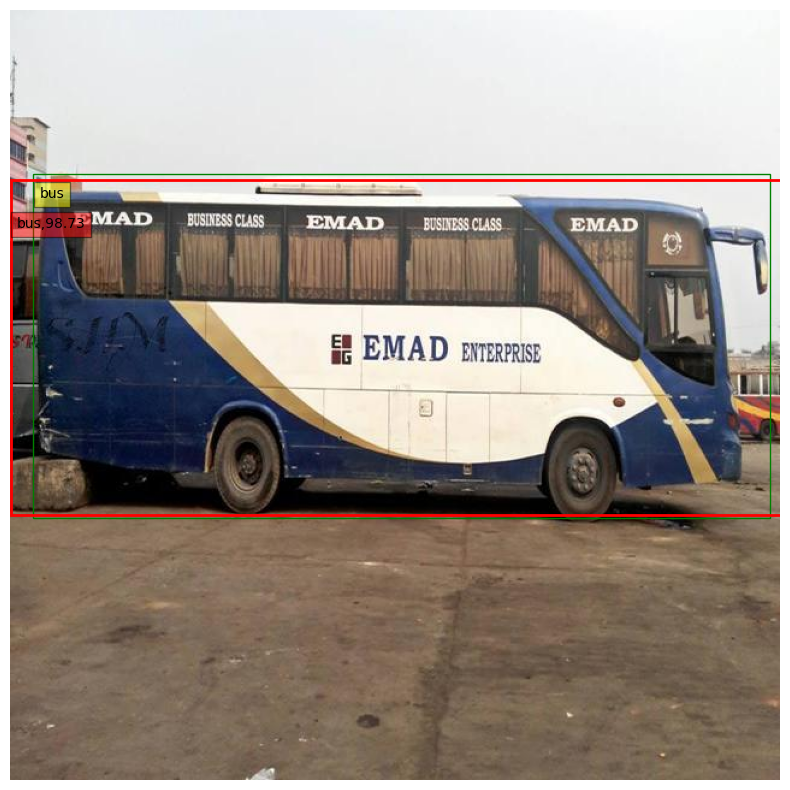

In [43]:
gts_cls = [i['category_id'] for i in ann_info]
gts_bbox = [[i['bbox'][0],
             i['bbox'][1],
             i['bbox'][0]+i['bbox'][2],
             i['bbox'][1]+i['bbox'][3]] for i in ann_info] # convert to xyxy

pred_boxes = result['unscaled_boxes']
pred_classes = result['pred_classes']
pred_scores = result['scores']

display_gt_pred(image_path=image_path,
                gt_boxes=gts_bbox,
                gt_class=gts_cls,
                pred_boxes=pred_boxes,
                pred_class=pred_classes,
                pred_scores=pred_scores,
                classnames=['Attention Please', 'Beware of children', 'Cycle route ahead warning', 'End of all speed and passing limits', 'Give Way', 'Go Straight or Turn left', 'Keep-Left', 'Left Zig Zag Traffic', 'Pedestrian', 'Pedestrian Crossing', 'Round-About', 'Slippery road ahead', 'Speed Limit 50 KMPh', 'Stop_Sign', 'Straight Ahead Only', 'Traffic_signal', 'Truck traffic is prohibited', 'Turn left ahead', 'Turn right ahead', 'bike', 'bus', 'car', 'cng', 'truck'],
                box_format='xyxy')